## Predicting Diabetes from Health Survey Data
##### Matilda Bae, Chris Tang, Angela Tangonan

### Introduction
Diabetes is a chronic ailment affecting millions of individuals in the United States and represents a significant public health concern worldwide. The disease is characterized by elevated blood sugar levels and heightened risks for major health complications requiring lifelong management. Investigating the prevalence and risk factors for diabetes can help drive efforts to identify individuals at risk and tailor preventative strategies specifically to them.

The Diabetes Health Indicators Dataset (2015) contains a valuable trove of data collected through the Behavioural Risk Factor Surveillance System, a national  telephone survey relating to health outcomes across the US. Our objective is to develop an accurate classification model for diabetes, and to pinpoint the variables in our survey response data with the greatest impact in predicting diabetes.

### Preliminary exploratory data analysis

In [8]:
# Loading in Libraries
library(tidyverse)
library(RColorBrewer)
library(tidymodels)

# Loading in data
url <- 'https://github.com/MatildaBae/dsci-100-2023W1-group45/raw/main/data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
diab_data <- read_csv(url)

# Inspecting data
glimpse(diab_data)

Rows: 70692 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_binary, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 70,692
Columns: 22
$ Diabetes_binary      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ HighBP               <dbl> 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0…
$ HighChol             <dbl> 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0…
$ CholCheck            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ BMI                  <dbl> 26, 26, 26, 28, 29, 18, 26, 31, 32, 27, 24, 21, 2…
$ Smoker               <dbl> 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0…
$ Stroke               <dbl> 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ HeartDiseaseorAttack <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0…
$ PhysActivity         <dbl> 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1…
$ Fruits               <dbl> 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0…
$ Veggies              <dbl> 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1…
$ HvyAlcoholConsump    <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ AnyHealthcare

There are over seventy-thousand observations in these data across twenty-two variables. Many variables encode binary data which we should convert to factors before continuing.

In [9]:
# Setting factor levels for age bins
age_levels <- c('[18,24]', 
                '[25,29]', 
                '[30,34]', 
                '[35,39]', 
                '[40,44]', 
                '[45,49]', 
                '[50,54]', 
                '[55,59]', 
                '[60,64]', 
                '[65,69]', 
                '[70,74]', 
                '[75,79]', 
                '[79,∞)')

# Converting column classes appropriately
diab_data <- diab_data %>% 
        mutate(across(everything(), as_factor)) %>%
        mutate(Diabetes_binary = fct_recode(Diabetes_binary, 'Case' = '1', 'Control' = '0')) %>%  ## Recoding outcome column ##
        mutate(Diabetes_binary = factor(Diabetes_binary, levels = c('Case', 'Control'))) %>%       # Cases    - diabetes     #
        mutate(Sex = fct_recode(Sex, 'Female' = '0', 'Male' = '1')) %>%                            # Controls - no diabetes  #
        mutate(Sex = factor(Sex, levels = c('Male', 'Female'))) %>%
        mutate(Age = fct_recode(Age,                               # Recoding age column to corresponding bins for greater interpretability
                                '[18,24]' = '1',
                                '[25,29]' = '2',
                                '[30,34]' = '3',
                                '[35,39]' = '4',
                                '[40,44]' = '5',
                                '[45,49]' = '6',
                                '[50,54]' = '7',
                                '[55,59]' = '8',
                                '[60,64]' = '9',
                                '[65,69]' = '10',
                                '[70,74]' = '11',
                                '[75,79]' = '12',
                                '[79,∞)' = '13')) %>%
        mutate(Age = factor(Age, levels = age_levels)) %>%
        mutate(BMI = as.numeric(BMI),
               MentHlth = as.numeric(MentHlth),
               GenHlth = as.numeric(GenHlth))

# Table examining NA counts across variables
map_df(diab_data, ~ sum(is.na(.)))

# Table examining counts in each class
diab_data %>% count(Diabetes_binary)

Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,⋯,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Diabetes_binary,n
<fct>,<int>
Case,35346
Control,35346


The data is already in tidy format. There are no NA values in any of our columns. There are an equal number of respondents with diabetes (cases) and without diabetes (controls). Thus, we will not have to worry about class imbalances. 

We now randomly sample 75% of our data to create a training set, using which we will summarize some variables in greater detail.

In [10]:
# Setting seed for reproducibility, splitting data into 
set.seed(1234);

diab_split <- diab_data %>% 
                initial_split(prop = 0.75, strata = Diabetes_binary)
diab_train <- training(diab_split)

# Exploring BMI data
summary_bmi <- diab_data %>%
        select(Diabetes_binary, BMI) %>%
        group_by(Diabetes_binary) %>%
        summarize(mean_BMI = mean(BMI),
                  sd_BMI = sd(BMI))

# Printing BMI summary statistics table
summary_bmi

mean_bmi_case <- summary_bmi %>% 
        filter(Diabetes_binary == 'Case') %>% 
        pull(mean_BMI)
mean_bmi_control <- summary_bmi %>% 
        filter(Diabetes_binary == 'Control') %>% 
        pull(mean_BMI)

Diabetes_binary,mean_BMI,sd_BMI
<fct>,<dbl>,<dbl>
Case,20.94277,7.353156
Control,16.76897,6.177333


Warning message:
“Removed 140 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


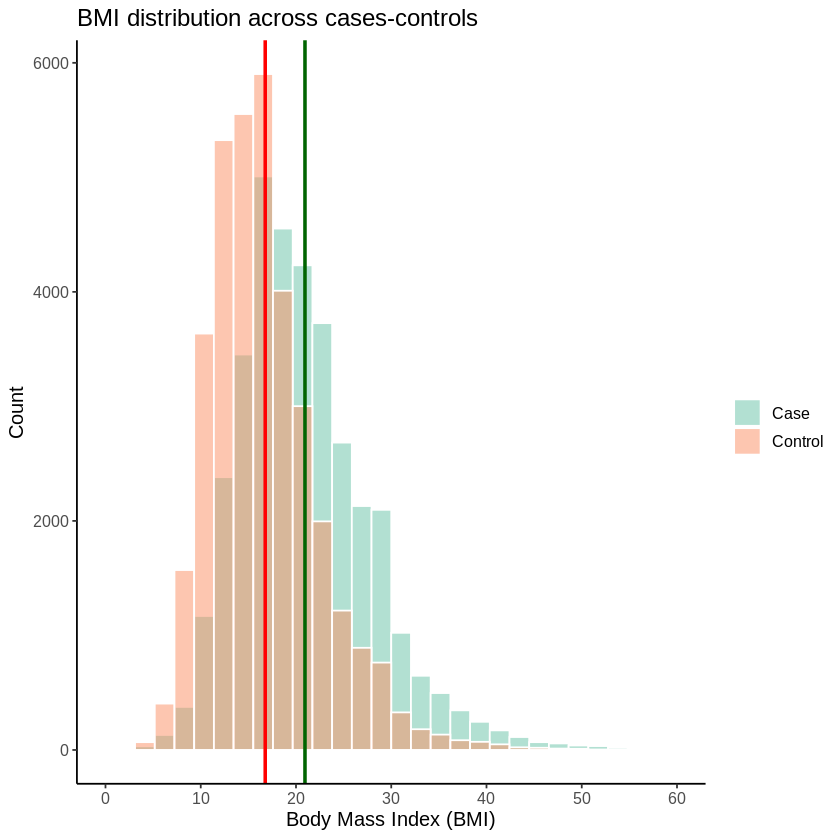

In [11]:
# Plotting BMI frequency
bmi_plot <- diab_data %>%
        ggplot(aes(x = BMI, fill = Diabetes_binary)) +
        geom_histogram(bins = 30, 
                       color = 'white',
                       size = 0.5,
                       alpha = 0.5,
                       position = 'identity') +
        geom_vline(xintercept = mean_bmi_case, color = 'darkgreen', linewidth = 1) +
        geom_vline(xintercept = mean_bmi_control, color = 'red', linewidth = 1) +
        scale_x_continuous(limits = c(0, 60),
                           breaks = seq(0, 60, 10)) +
        labs(x = 'Body Mass Index (BMI)', 
             y = 'Count',
             fill = '') +
        ggtitle('BMI distribution across cases-controls') +
        scale_fill_brewer(palette = 'Set2') +
        theme_classic() +
        theme(text = element_text(size = 12))

bmi_plot

The red line represents the mean BMI in the control population, the green line represents the same for cases. 

The distribution plot and table indicate that respondents with diabetes generally have a higher BMI compared to controls. Both populations are right-skewed, representing the respondents with very high BMIs.

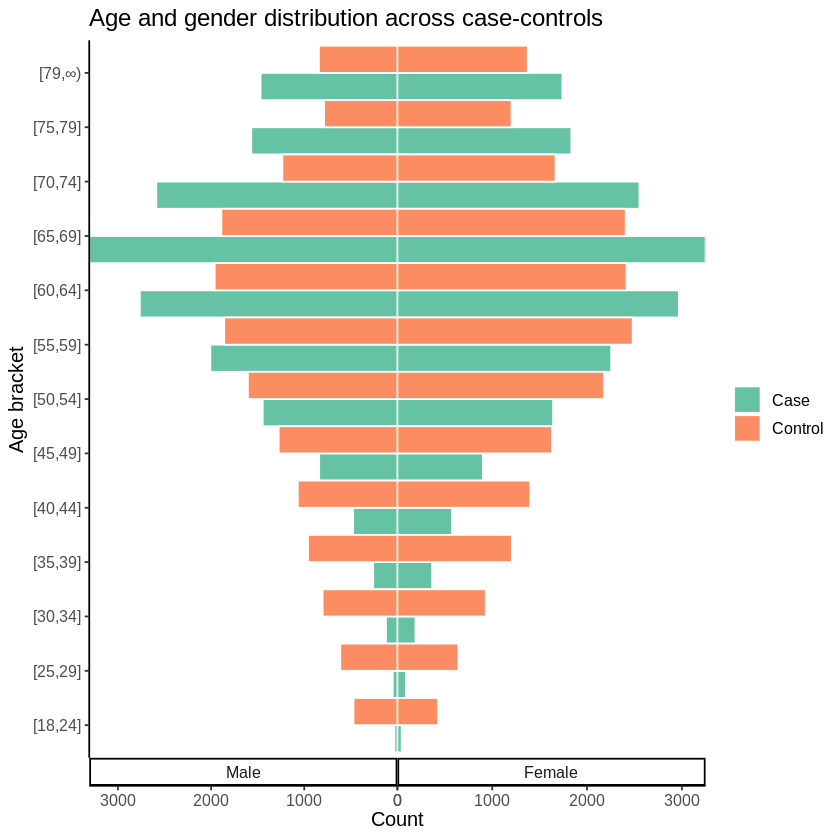

In [12]:
# Population plot
pop_plot <- diab_data %>% 
                count(Diabetes_binary, 
                      Age, 
                      Sex) %>%
                mutate(n = ifelse(Sex == 'Male', 
                                  n * -1, 
                                  n)) %>%
                ggplot(aes(x = Age, 
                           y = n, 
                           fill = Diabetes_binary)) +
                geom_bar(stat = 'identity', 
                         position = 'dodge',
                         color = 'white',
                         width = 1) +
                labs(x = 'Age bracket', 
                     y = 'Count',
                     fill = '') +
                ggtitle('Age and gender distribution across case-controls') +
                coord_flip() +
                scale_fill_brewer(palette = 'Set2') +
                theme_classic() +
                scale_y_continuous(labels = abs,
                                   expand = c(0,0)) +
                facet_wrap(~Sex, 
                           strip.position = 'bottom', 
                           scale = 'free_x') +
                theme(text = element_text(size = 12), 
                      panel.spacing.x = unit(0, 'pt'))
pop_plot

This population pyramid plot shows that respondents were most likely to be 60 to 70 years old. Generally, respondents were more likely to have diabetes the older they were.

There are roughly an even number of female and male survey respondents in both case and control populations.

Diabetes_binary,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Case,0.7526736,0.6701183,0.9931817,0.5182199,0.09245742,0.22288236,0.6305381,0.5854411,0.7564081,0.02353873,0.9597691,0.10586771,0.3712160
Control,0.3742432,0.3812878,0.9573360,0.4323261,0.03188480,0.07273808,0.7755333,0.6381486,0.8211396,0.06190234,0.9501499,0.08196118,0.1342443


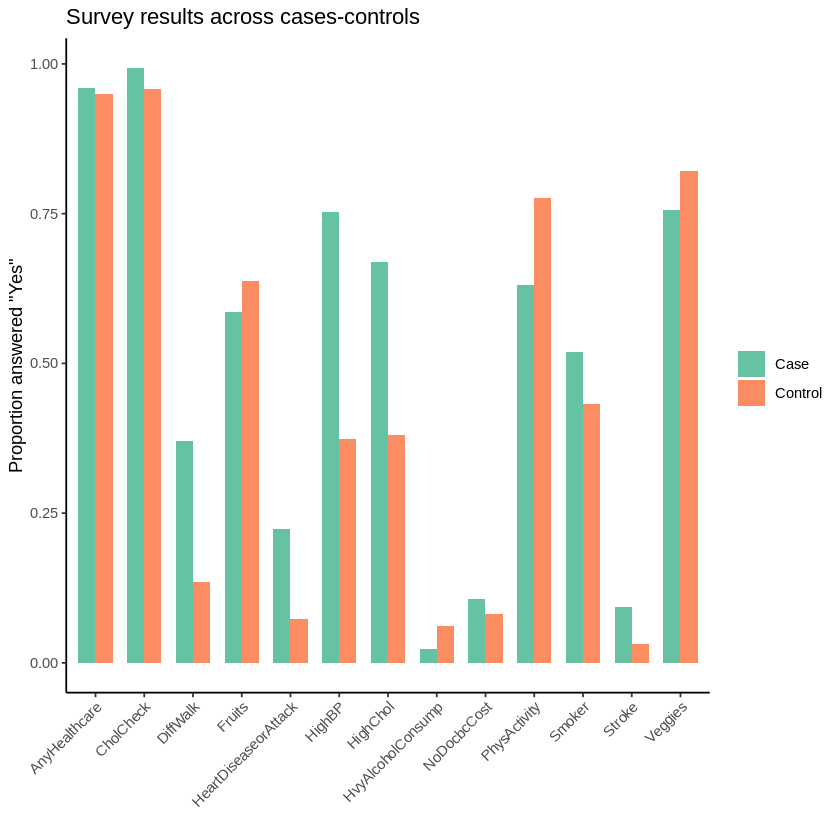

In [13]:
# Examining data for binary yes-or-no questions
diab_summary <- diab_data %>% 
        select(-Sex) %>%
        group_by(Diabetes_binary) %>% 
        summarize(across(where(~ is.factor(.x) && length(unique(.x)) == 2), ~ sum(. == "1") / n(), .names = '{.col}'))

# Table showing proportion of respondents that answered "Yes" to the questions encoded in the variables
diab_summary

# Plotting survey data
survey_plot <- diab_summary %>%
        pivot_longer(!Diabetes_binary) %>%
        ggplot(aes(x = name, y = value, fill = Diabetes_binary)) +
        geom_bar(stat = 'identity', position = 'dodge', width = 0.7) +
        labs(x = '', y = 'Proportion answered "Yes"', fill = '') +
        ggtitle("Survey results across cases-controls") +
        scale_fill_brewer(palette = 'Set2') +
        theme_classic() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

survey_plot

In this bar plot, we observe some divergence between cases and controls. Respondents were more likely to answer "Yes" when asked if they have high blood pressure (HighBP) or high cholesterol (HighChol) if they had diabetes. These variables have the potential to serve as valuable predictors in our eventual classification model.

### Methods
We will identify 5 to 10 variables that potentially have the highest predictive power for diabetes. We will perform a short literature search, coupled with some data exploration techniques plus forward selection, to select for those features that are most influential when determining diabetes risk.
We will employ a cross-validation approach to train different classification models, including random forest and/or logistic regression models, to predict diabetes. We will investigate the relative contributions of our predictors in our model through variable importance analysis. Statistical transformations such as PCA, PCoA, and T-SNE will be used to visualize our multidimensional dataset.

### Expected outcomes and significance
Our aim is to determine whether we can develop an accurate model for diabetes given clinical and demographic data. We expect to identify, among the variables selected as predictors, which predictors carry the highest predictive power in our classification model. This model could aid in the early detection of diabetes, allowing for timely intervention and better disease management. The variables identified could help healthcare providers create personalized treatment plans for individuals based on their risk factors and characteristics. Further questions that may arise include whether the model can be refined to differentiate between diabetes subtypes and whether there are predictive variables associated with each subtype.